In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from geopy.distance import geodesic

In [3]:
bike_data = pd.read_csv('data/202401-citibike-tripdata.csv')

/var/folders/8c/3n532t214sl7q0wy9wf_qks00000gn/T/ipykernel_93422/1755489540.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  bike_data = pd.read_csv('202401-citibike-tripdata.csv')


In [4]:
bike_data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,5078F3D302000BD2,electric_bike,2024-01-22 18:43:19.012,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,7954.12,St Nicholas Ave & W 126 St,7756.10,40.823072,-73.941738,40.811432,-73.951878,member
1,814337105D37302A,electric_bike,2024-01-11 19:19:18.721,2024-01-11 19:47:36.007,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761822,-73.977036,40.768974,-73.954823,member
2,A33A920E2B10710C,electric_bike,2024-01-30 19:17:41.693,2024-01-30 19:32:49.857,E 11 St & Ave B,5659.11,W 10 St & Washington St,5847.06,40.727592,-73.979751,40.733424,-74.008515,casual
3,A3A5FC0DD7D34D74,electric_bike,2024-01-27 11:27:01.759,2024-01-27 11:38:01.213,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761779,-73.977144,40.768974,-73.954823,member
4,6F96728ECEFBDAA4,electric_bike,2024-01-16 15:15:41.000,2024-01-16 15:29:26.156,Madison Ave & E 99 St,7443.01,E 74 St & 1 Ave,6953.08,40.789808,-73.952214,40.768974,-73.954823,member


In [19]:
bike_data.shape

(1887534, 17)

In [20]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1887534 entries, 0 to 1888084
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ride_id                object        
 1   rideable_type          object        
 2   started_at             datetime64[ns]
 3   ended_at               datetime64[ns]
 4   start_station_name     object        
 5   start_station_id       object        
 6   end_station_name       object        
 7   end_station_id         object        
 8   start_lat              float64       
 9   start_lng              float64       
 10  end_lat                float64       
 11  end_lng                float64       
 12  member_casual          object        
 13  duration               float64       
 14  distance               float64       
 15  member_casual_encoded  int64         
 16  anomaly                int64         
dtypes: datetime64[ns](2), float64(6), int64(2), object(7)
memory usage: 25

In [21]:
bike_data.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,duration,distance,member_casual_encoded,anomaly
count,1887534,1887534,1.887534e+06,1.887534e+06,1.887534e+06,1.887534e+06,1.887534e+06,1.887534e+06,1.887534e+06,1.887534e+06
mean,2024-01-16 16:51:14.940449792,2024-01-16 17:02:19.829908224,4.073898e+01,-7.397188e+01,4.073888e+01,-7.397208e+01,1.108149e+01,1.785632e+00,8.897816e-01,6.000030e-01
min,2023-12-31 13:49:02.295000,2024-01-01 00:00:08.272000,4.056315e+01,-7.402699e+01,4.058000e+01,-7.406692e+01,1.000733e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,2024-01-08 17:12:42.258749952,2024-01-08 17:24:10.579500032,4.071495e+01,-7.399164e+01,4.071503e+01,-7.399177e+01,4.667933e+00,7.835072e-01,1.000000e+00,1.000000e+00
50%,2024-01-15 16:52:55.184500224,2024-01-15 17:02:28.954500096,4.073932e+01,-7.397964e+01,4.073913e+01,-7.397974e+01,7.740258e+00,1.335141e+00,1.000000e+00,1.000000e+00
75%,2024-01-25 11:33:36.487249920,2024-01-25 11:44:27.439499776,4.076193e+01,-7.395587e+01,4.076171e+01,-7.395596e+01,1.299505e+01,2.278759e+00,1.000000e+00,1.000000e+00
max,2024-01-31 23:58:30.270000,2024-01-31 23:59:56.370000,4.088636e+01,-7.384962e+01,4.092000e+01,-7.379000e+01,1.500492e+03,2.589845e+01,1.000000e+00,1.000000e+00
std,NaN,NaN,4.003402e-02,2.818276e-02,3.990145e-02,2.816227e-02,2.225604e+01,1.549585e+00,3.131619e-01,7.999980e-01


# Feature Engineering

In [7]:
# Check for NaN values in latitude and longitude columns
print(bike_data[['start_lat', 'start_lng', 'end_lat', 'end_lng']].isnull().sum())


start_lat      0
start_lng      0
end_lat      551
end_lng      551
dtype: int64


In [8]:
# Drop rows with NaN values in latitude and longitude columns
bike_data = bike_data.dropna(subset=['end_lat', 'end_lng'])

## Calculate Duration (in minutes)

In [18]:
bike_data['started_at'] = pd.to_datetime(bike_data['started_at'])
bike_data['ended_at'] = pd.to_datetime(bike_data['ended_at'])
bike_data['duration'] = (bike_data['ended_at'] - bike_data['started_at']).dt.total_seconds() / 60  # convert to minutes


## Calculate Distance (in kilometers) using geodesic distance

In [6]:
def calculate_distance(row):
    start_coords = (row['start_lat'], row['start_lng'])
    end_coords = (row['end_lat'], row['end_lng'])
    return geodesic(start_coords, end_coords).kilometers

In [9]:
bike_data['distance'] = bike_data.apply(calculate_distance, axis=1)

## Encode the 'member_casual' column

In [10]:
label_encoder = LabelEncoder()
bike_data['member_casual_encoded'] = label_encoder.fit_transform(bike_data['member_casual'])


## Select relevant features

In [11]:
# Select relevant features for anomaly detection
features = ['duration', 'distance', 'member_casual_encoded']
X = bike_data[features]


# Train Isolation Forest

In [12]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.2)  # Adjust contamination as needed

# Fit the model to the data
bike_data['anomaly'] = iso_forest.fit_predict(X)


# Plot the Anomalies

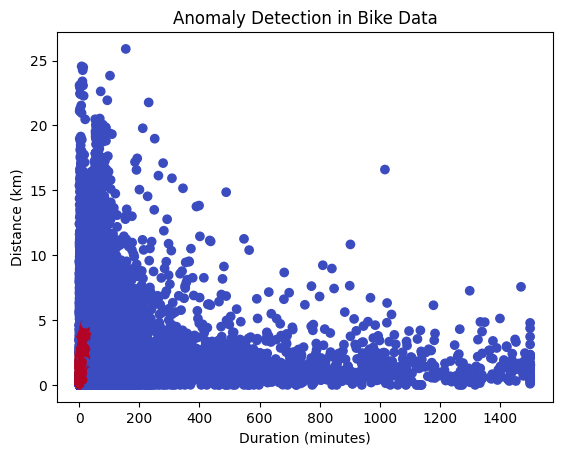

             ride_id  rideable_type              started_at  \
1   814337105D37302A  electric_bike 2024-01-11 19:19:18.721   
2   A33A920E2B10710C  electric_bike 2024-01-30 19:17:41.693   
7   8C9510DC30F25AE9  electric_bike 2024-01-10 13:17:55.729   
10  72718D2CD66FA369  electric_bike 2024-01-10 16:04:05.904   
14  858BC46AED23DC0D  electric_bike 2024-01-11 18:09:13.461   

                  ended_at     start_station_name start_station_id  \
1  2024-01-11 19:47:36.007        W 54 St & 6 Ave          6771.13   
2  2024-01-30 19:32:49.857        E 11 St & Ave B          5659.11   
7  2024-01-10 13:25:12.004  Columbia St & Kane St          4422.05   
10 2024-01-10 16:18:38.812        W 54 St & 6 Ave          6771.13   
14 2024-01-11 18:28:04.308        E 11 St & Ave B          5659.11   

                       end_station_name end_station_id  start_lat  start_lng  \
1                       E 74 St & 1 Ave        6953.08  40.761822 -73.977036   
2               W 10 St & Washington St 

In [13]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_data['duration'], bike_data['distance'], c=bike_data['anomaly'], cmap='coolwarm')
plt.xlabel('Duration (minutes)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike Data')
plt.show()

# Print detected anomalies
anomalies = bike_data[bike_data['anomaly'] == -1]
print(anomalies.head())

In [17]:
# Separate data by member type
members = bike_data[bike_data['member_casual_encoded'] == 0]
casuals = bike_data[bike_data['member_casual_encoded'] == 1]



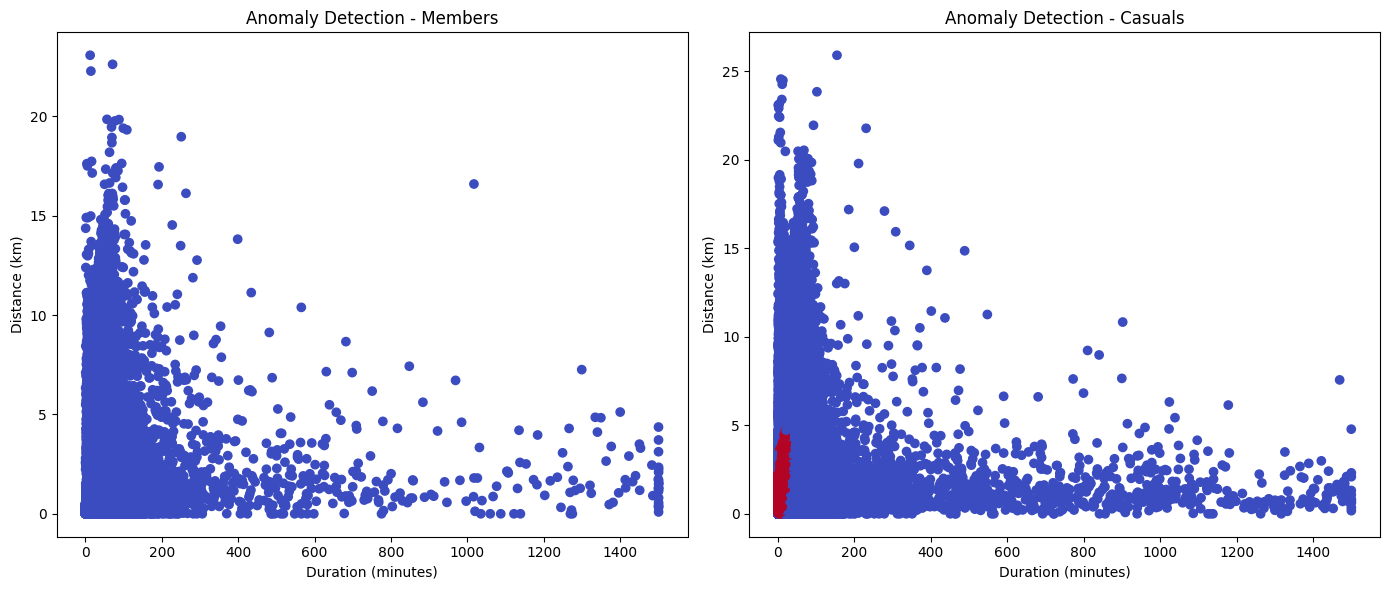

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for members
ax[0].scatter(members['duration'], members['distance'], c=members['anomaly'], cmap='coolwarm')
ax[0].set_title('Anomaly Detection - Members')
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('Distance (km)')

# Plot for casuals
ax[1].scatter(casuals['duration'], casuals['distance'], c=casuals['anomaly'], cmap='coolwarm')
ax[1].set_title('Anomaly Detection - Casuals')
ax[1].set_xlabel('Duration (minutes)')
ax[1].set_ylabel('Distance (km)')

# Show the plots
plt.tight_layout()
plt.show()